In [1]:
%load_ext autoreload
%autoreload 2

import os

import cv2
import numpy as np
import scipy.linalg
from matplotlib import pyplot as plt

In [2]:
# Common functions

def cv_draw_lines(img_rgb, lines, fgcolor=(255,255,255), bgcolor=(0,0,255)):
    img_height, img_width = img_rgb.shape[:2]
    for lx, ly, lz in lines:
        if abs(ly) > 1e-5:
            x1, x2 = int(0), int(img_width - 1)
            y1, y2 = int((-lz - lx * x1) / ly), int((-lz - lx * x2) / ly)
            if abs(y1) >= 1e5 or abs(y2) > 1e5:
                print(f". overflow line: ({lx}, {ly}, {lz})")
                continue
        else:
            y1, y2 = int(0), int(img_height - 1)
            x1, x2 = int((-lz - ly * y1) / lx), int((-lz - ly * y2) / lx)
            if abs(x1) >= 1e5 or abs(x2) > 1e5:
                print(f". overflow line: ({lx}, {ly}, {lz})")
                continue
        cv2.line(img_rgb, (x1, y1), (x2, y2), color=bgcolor, thickness=3)
        cv2.line(img_rgb, (x1, y1), (x2, y2), color=fgcolor, thickness=2)
    return img_rgb

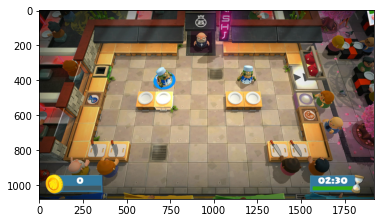

In [3]:
# Load image and interactive view to identify keypoints

img_path = "./overcooked2.png"
img_frame = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)

# Press any key to close pop-up
cv2.imshow("image", cv2.cvtColor(img_frame, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(img_frame)

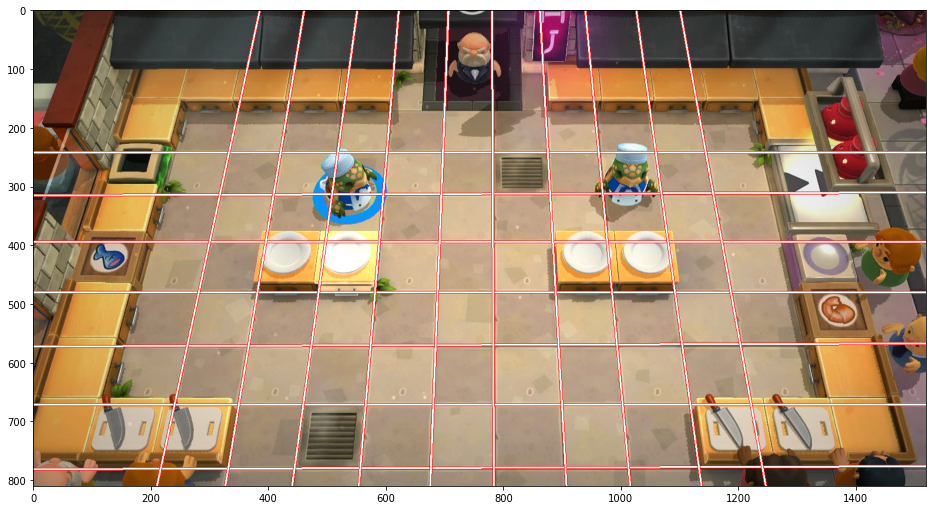

In [4]:
# Define line correspondences

num_pixels_per_tile = 100

img_grid_height, img_grid_width = 8*num_pixels_per_tile, 13*num_pixels_per_tile

# Crop image
img_in = img_frame[90:900, 180:1700]

# 7 horz lines on ground plane starting with row=2, 10 vert lines starting with col 2
lines_img = np.array([
    # horz lines
    #  [ 0.00000000e+00, -5.00000000e-01, 1.00000000e+00],
    #  [ 0.00000000e+00, -1.01010101e-02, 1.00000000e+00],
    #  [-2.22828459e-05, -6.38353920e-03, 1.00000000e+00],
     [ 0.00000000e+00, -4.11522634e-03, 1.00000000e+00],
     [-1.10585791e-05, -3.16803668e-03, 1.00000000e+00],
     [ 0.00000000e+00, -2.53164557e-03, 1.00000000e+00],
     [ 0.00000000e+00, -2.08333333e-03, 1.00000000e+00],
     [-6.09561676e-06, -1.74625848e-03, 1.00000000e+00],
     [ 0.00000000e+00, -1.48809524e-03, 1.00000000e+00],
     [-4.46575792e-06, -1.27934021e-03, 1.00000000e+00],
    # vert lines
    #  [-4.51521150e-03, -1.43230946e-03, 1.00000000e+00],
    #  [-3.44820909e-03, -9.11056140e-04, 1.00000000e+00],
     [-2.59360247e-03, -5.60756702e-04, 1.00000000e+00],
     [-2.16897478e-03, -3.59071447e-04, 1.00000000e+00],
     [-1.81330864e-03, -2.48392386e-04, 1.00000000e+00],
     [-1.60769430e-03, -1.35001862e-04, 1.00000000e+00],
     [-1.41531091e-03, -5.43707610e-05, 1.00000000e+00],
     [-1.27944928e-03,  4.46613865e-06, 1.00000000e+00],
     [-1.15961257e-03,  6.48324079e-05, 1.00000000e+00],
     [-1.06415104e-03,  1.00591890e-04, 1.00000000e+00],
     [-9.74163336e-04,  1.33443778e-04, 1.00000000e+00],
     [-9.08158809e-04,  1.63403561e-04, 1.00000000e+00],
    #  [-8.24761468e-04,  1.84356030e-04, 1.00000000e+00],
    #  [-7.90596257e-04,  2.26699829e-04, 1.00000000e+00],
    #  [-7.46843433e-04,  2.39785194e-04, 1.00000000e+00],
     ])

lines_grid = np.array([ # -1 in w so that these lines do not have w=0, else cannot whiten (at least easily)
    # horz lines
    [0, 1, -2*num_pixels_per_tile-1],
    [0, 1, -3*num_pixels_per_tile-1],
    [0, 1, -4*num_pixels_per_tile-1],
    [0, 1, -5*num_pixels_per_tile-1],
    [0, 1, -6*num_pixels_per_tile-1],
    [0, 1, -7*num_pixels_per_tile-1],
    [0, 1, -8*num_pixels_per_tile-1],
    # vert lines
    [1, 0, -2*num_pixels_per_tile-1],
    [1, 0, -3*num_pixels_per_tile-1],
    [1, 0, -4*num_pixels_per_tile-1],
    [1, 0, -5*num_pixels_per_tile-1],
    [1, 0, -6*num_pixels_per_tile-1],
    [1, 0, -7*num_pixels_per_tile-1],
    [1, 0, -8*num_pixels_per_tile-1],
    [1, 0, -9*num_pixels_per_tile-1],
    [1, 0, -10*num_pixels_per_tile-1],
    [1, 0, -11*num_pixels_per_tile-1],
])

# Visualize
plt.figure(figsize=(16,10))
img_overlay = cv_draw_lines(img_in.copy(), lines_img, fgcolor=(255,255,255), bgcolor=(255,0,0))
plt.imshow(img_overlay)

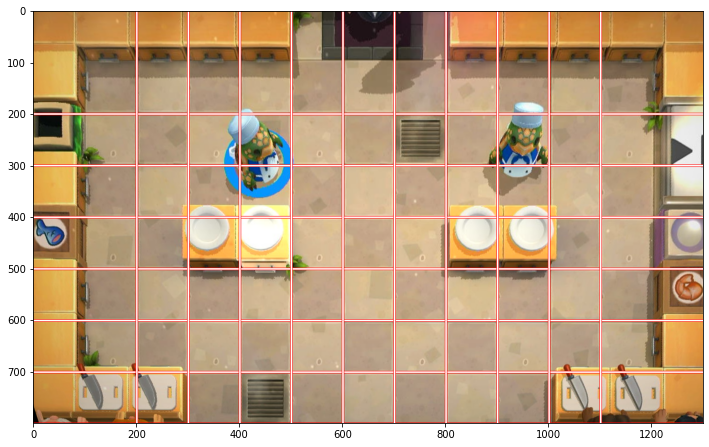

In [5]:
## Algorithm 4.2: The normalized DLT for 2D homographies (for line correspondences)

# - want: pt_img = H * pt_grid
# - solve: line_img = H' * line_grid, where H' = H^-T

def whiten_xyw(Xs):
    xys = Xs[:, :2] / np.expand_dims(Xs[:, 2], axis=1)
    xys_mean = np.mean(xys, axis=0)
    xy_gain = np.sqrt(2) / np.mean(np.linalg.norm(xys - xys_mean, axis=1))
    xys_whitened = (xys - xys_mean) * xy_gain
    Xs_whitened = np.hstack((xys_whitened, np.ones((xys.shape[0], 1))))
    return Xs_whitened, xys_mean, xy_gain

def dlt(Xs_prime, Xs):
    """
    Direct Linear Transform: returns homography that maps from Xs to Xs_prime.
    Follows MVG eqn. (4.3).

    WARNING: does not work for entry of the form (x, y, w=0).

    @param Xs_prime: (N x 3) homogeneous points in target space
    @param Xs: (N x 3) homogeneous points in source space

    @return H_prime_orig: (3 x 3) homography from source to target
    """

    # Whiten both entries: shift to xy centroid + rescale to avg length of sqrt(2)
    Xs_prime_whitened, Xs_prime_mean, Xs_prime_gain = whiten_xyw(Xs_prime)
    Xs_whitened, Xs_mean, Xs_gain = whiten_xyw(Xs)

    # Build A matrix
    num_correspondences = len(Xs)
    A = np.zeros((2 * num_correspondences, 9))
    for idx, (X_prime, X) in enumerate(zip(Xs_prime_whitened, Xs_whitened)):
        x_prime, y_prime, w_prime = X_prime
        A[2 * idx, 3:6] = -w_prime*X
        A[2 * idx, 6:9] = y_prime*X
        A[2 * idx + 1, 0:3] = w_prime*X
        A[2 * idx + 1, 6:9] = -x_prime*X

    # Solve for h vector via SVD null-space
    _, _, V = scipy.linalg.svd(A)
    h_w_prime_orig = V[-1, :]  # w = whitened
    H_w_prime_orig = np.reshape(h_w_prime_orig, (3, 3)) / h_w_prime_orig[-1]

    T_from_orig = np.array(((Xs_gain, 0, -Xs_mean[0] * Xs_gain), (0, Xs_gain, -Xs_mean[1] * Xs_gain), (0, 0, 1)))
    T_to_prime = np.array(((1/Xs_prime_gain, 0, Xs_prime_mean[0]), (0, 1/Xs_prime_gain, Xs_prime_mean[1]), (0, 0, 1)))
    H_prime_orig = T_to_prime @ H_w_prime_orig @ T_from_orig

    return H_prime_orig

H_l_img_grid = dlt(Xs_prime=lines_img, Xs=lines_grid)  # l = line
H_grid_img = H_l_img_grid.transpose()  # the inv() from converting line to pt cancels out with grid/img swap

# Warp plane in image into grid space
img_grid = cv2.warpPerspective(img_in, H_grid_img, dsize=(img_grid_width, img_grid_height))

# Visualize
plt.figure(figsize=(12, 8))
img_overlay = cv_draw_lines(img_grid.copy(), lines_grid, fgcolor=(255,255,255), bgcolor=(255,0,0))
plt.imshow(img_overlay)
plt.show()